# Оптимизировация производственных расходов

## Введение
Для оптимизирования производственных расходов, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Задача состоит в том, чтобы построить модель, которая предскажет температуру стали.


### План работы

1. Подготовка данных:
        1.1. Открытие и изучиние файлов;
        1.2. Предобработка данных;
        1.3. Подготовка признаков(создание таблицы с признаками и таргетом)
2. Обучение модели:
        2.1. 
        2.2.  
3. Тестирование модели:
4. Вывод.





### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

In [2]:
data_arc = pd.read_csv('datasets\\final_steel\\data_arc.csv')
data_bulk_time = pd.read_csv('datasets\\final_steel\\data_bulk_time.csv')
data_gas = pd.read_csv('datasets\\final_steel\\data_gas.csv')
data_temp = pd.read_csv('datasets\\final_steel\\data_temp.csv')
data_wire = pd.read_csv('datasets\\final_steel\\data_wire.csv')
data_wire_time = pd.read_csv('datasets\\final_steel\\data_wire_time.csv')
data_bulk = pd.read_csv('datasets\\final_steel\\data_bulk.csv')


'''
data_arc = pd.read_csv(
    '/datasets/final_steel/data_arc.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')'''

"\ndata_arc = pd.read_csv(\n    '/datasets/final_steel/data_arc.csv')\ndata_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')\ndata_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')\ndata_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')\ndata_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')\ndata_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')\ndata_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')"

## 1. Подготовка данных
### 1.1 Данные об электродах
#### Открытие и изучение

In [3]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


##### Вывод

Следует привести названия столбцов к стандарту, преобразовать дату и время к формату datetime, найти и избавиться от выбросов, если такие есть.

#### Предобработка данных

In [5]:
# Замена названий столбцов

data_arc = data_arc.rename({'Начало нагрева дугой':'start', 'Конец нагрева дугой':'end',
       'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, axis=1)


# Преобразование даты и времени к формату datetime

data_arc['start'] =  pd.to_datetime(data_arc['start'], format='%Y%m%d %H:%M:%S')
data_arc['end'] =  pd.to_datetime(data_arc['end'], format='%Y%m%d %H:%M:%S')


# Выделение времени нагрева в отдельный столбец

data_arc['time'] = data_arc['end'] - data_arc['start']
data_arc.time = data_arc.time.apply(lambda x: x.total_seconds()) # округление до секунд

In [6]:
# Проверка на дубликаты

data_arc.duplicated().sum()

0

In [7]:
data_arc.drop('key', axis=1).describe()

,active_power,reactive_power,time
count,14876.000000,14876.000000,14876.000000
mean,0.670441,0.452592,171.670946
std,0.408159,5.878702,98.186803
min,0.030002,-715.504924,11.000000
25%,0.395297,0.290991,107.000000
50%,0.555517,0.415962,147.000000
75%,0.857034,0.637371,214.000000
max,3.731596,2.676388,907.000000


У реактивной мощности выделяется минимальное значение крайне сильно.

In [8]:
data_arc[data_arc['reactive_power']<0]

,key,start,end,active_power,reactive_power,time
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109.0


Скорее всего, это выброс, связанной с ошибкой в записи.
Удалим выброс, так как количество меньше 1%.

In [9]:
data_arc = data_arc[data_arc['reactive_power']>=0] # удаление

In [10]:
data_arc = data_arc.groupby('key').sum()
data_arc.head(5)

,active_power,reactive_power,time
key,,,
1,4.878147,3.183241,1098.0
2,3.052598,1.998112,811.0
3,2.525882,1.599076,655.0
4,3.209250,2.060298,741.0
5,3.347173,2.252643,869.0


In [11]:
data_arc.describe()

,active_power,reactive_power,time
count,3214.000000,3214.000000,3214.000000
mean,3.102984,2.317442,794.545115
std,1.397556,1.054316,332.491076
min,0.186226,0.158247,57.000000
25%,2.126339,1.599018,571.000000
50%,2.990537,2.229869,770.000000
75%,3.901147,2.899141,983.000000
max,17.496497,12.587990,4189.000000


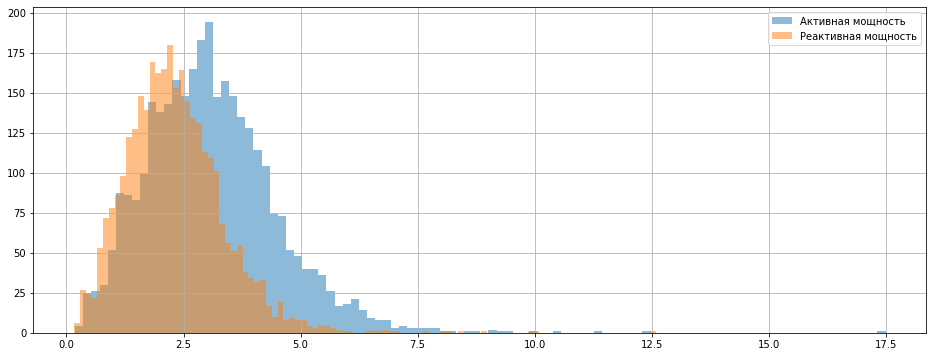

In [12]:
data_arc['active_power'].hist(bins=100, figsize=(16,6), alpha=0.5, label = 'Активная мощность')
data_arc['reactive_power'].hist(bins=100, figsize=(16,6), alpha=0.5, label = 'Реактивная мощность')
plt.legend()
plt.show()

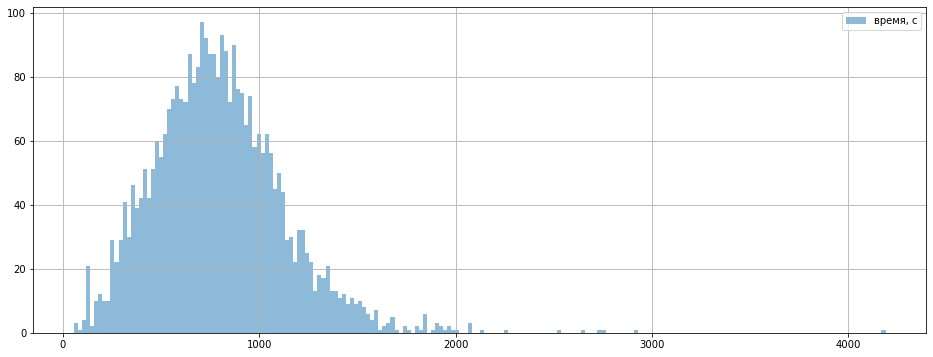

In [13]:
data_arc['time'].hist(bins=200, figsize=(16,6), alpha=0.5, label='время, с')
plt.legend()
plt.show()

<AxesSubplot:>

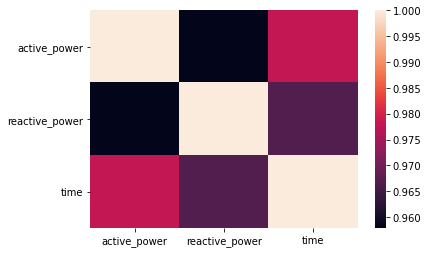

In [14]:
corr = data_arc.corr()
sns.heatmap(corr)

In [15]:
display(corr)

,active_power,reactive_power,time
active_power,1.000000,0.957892,0.978012
reactive_power,0.957892,1.000000,0.966837
time,0.978012,0.966837,1.000000


Слишком большой процент корреляции у схожих признаков, объеденим их в один столбец полная мощность 'f_power' по формуле:

Полная мощность = √ (Активная мощность2 – Реактивная мощность2)


In [16]:
data_arc['f_power'] = np.sqrt(np.add((np.power(data_arc['active_power'],2)),(np.power(data_arc['reactive_power'],2))))

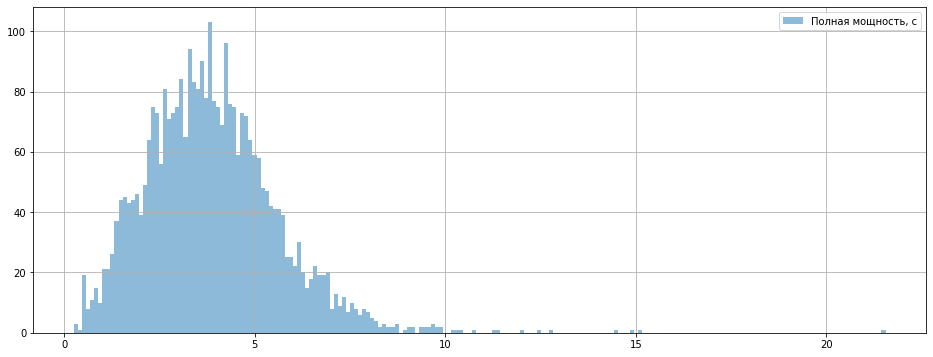

In [17]:

data_arc['f_power'].hist(bins=200, figsize=(16,6), alpha=0.5, label='Полная мощность, с')
plt.legend()
plt.show()

Удалим реактивную и активную мощность.

In [18]:
data_arc = data_arc.drop(['reactive_power', 'active_power'], axis=1)

In [19]:
data_arc.head(5)

,time,f_power
key,,
1,1098.0,5.824889
2,811.0,3.648398
3,655.0,2.989502
4,741.0,3.813674
5,869.0,4.034596


### 1.2 Данные о подаче сыпучих материалов (объём)
#### Открытие и изучение

In [20]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [21]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


##### Вывод
В данных очень много пропусков, вероятно, это связано с отсутвием подачи материалов. Поэтому заполним все пропуски нулём.
Также необходимо привести названия столбцов к стандарту: избавиться от заглавной буквы и от пробела.

#### Предобработка данных

In [22]:
# Замена пропущенных значений
data_bulk = data_bulk.fillna(0)
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [23]:
# Замена названий столбцов

data_bulk = data_bulk.rename({'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4',
                              'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8',
                              'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12',
                              'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'}, axis=1)
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [24]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### 1.3 Данные о подаче сыпучих материалов (время)
#### Открытие и изучение

In [25]:
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [26]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


##### Вывод 
Данные дублируют информацию об объёме. В дальнейшем анализе данные о времени подачи сыпучих материалов использованы не будут.

### 1.4 Данные о продувке сплава газом
#### Открытие и изучение

In [27]:
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [28]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


##### Вывод 
Необходимо привести название столбца к стандарту.

#### Предобработка данных

In [29]:
# Замена названия столбца
data_gas = data_gas.rename({'Газ 1':'gas_1'}, axis=1)

In [30]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


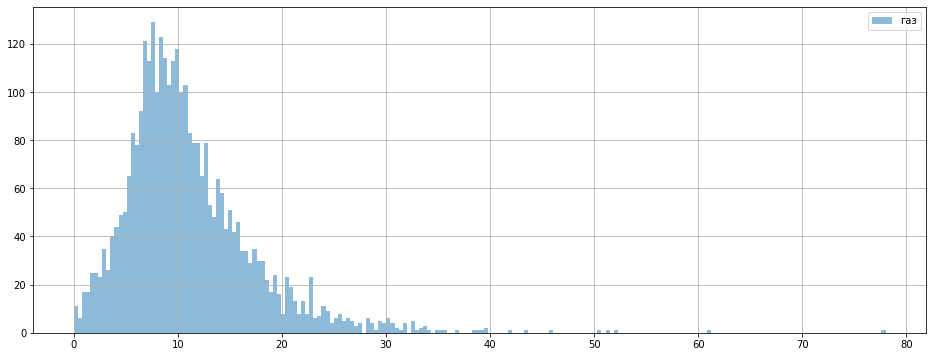

In [31]:
data_gas['gas_1'].hist(bins=200, figsize=(16,6), alpha=0.5, label='газ')
plt.legend()
plt.show()

##### Вывод 
На графике распределения видны выбросы газа, среднее значение равно 11.

### 1.5  Результаты измерения температуры
#### Открытие и изучение

In [32]:
data_temp.head(12)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


##### Вывод
Необходимо привести названия столбцов к стандарту. Также приведём тип столбца времени к нужному формату. 

Также данные избыточны, нас интересуют только последняя температура.

И нас не интересуют партии без промежуточных замеров, т.к. подобные партии не требуют оптимизации по технологическим параметрам.

#### Предобработка данных

In [34]:
# Замена названия столбца
data_temp = data_temp.rename({'Время замера':'measure_time', 'Температура':'temp'}, axis=1)
data_temp.columns

Index(['key', 'measure_time', 'temp'], dtype='object')

In [35]:
# Приведение названия столбца к стандарту
data_temp['measure_time'] =  pd.to_datetime(data_temp['measure_time'], format='%Y%m%d %H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [36]:
# Выборка ключей партий, где больше одного замера температуры 
last_measure = data_temp.groupby('key').max() # сгруппировали с выделением последнего замера температуры
count_temp = data_temp.groupby('key').count() # сгруппировали с подсчётом количества замеров

# объеденим last_measure и count_temp
merged = last_measure.merge(count_temp, left_index=True, right_index=True, how = 'right')

# объеденим merged и data_temp
target = merged.merge(data_temp, left_on='measure_time_x', right_on='measure_time', how = 'inner')

In [37]:
target.head(5)


,measure_time_x,temp_x,measure_time_y,temp_y,key,measure_time,temp
0,2019-05-03 11:30:39,1618.0,5,5,1,2019-05-03 11:30:39,1613.0
1,2019-05-03 11:59:12,1608.0,6,6,2,2019-05-03 11:59:12,1602.0
2,2019-05-03 12:34:57,1599.0,5,5,3,2019-05-03 12:34:57,1599.0
3,2019-05-03 12:59:25,1625.0,3,3,4,2019-05-03 12:59:25,1625.0
4,2019-05-03 13:36:01,1602.0,2,2,5,2019-05-03 13:36:01,1602.0


Получили таблицу с последнем замером и количеством замеров ['temp_y']. Дальше уберём данные, где нет промежуточных замеров. Также уберём лишние столбцы.

In [38]:
target = target[target['temp_y']>1].drop(['measure_time_x', 'temp_x', 'measure_time_y', 'temp_y'], axis=1)
target.head(5)

,key,measure_time,temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


In [39]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2475 non-null   int64         
 1   measure_time  2475 non-null   datetime64[ns]
 2   temp          2475 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.3 KB


In [40]:
display(target['temp'].describe())

count    2475.000000
mean     1595.336162
std        16.023153
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: temp, dtype: float64

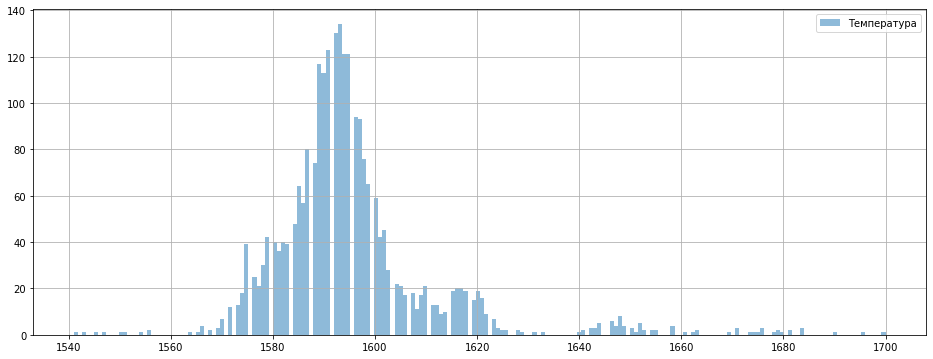

In [41]:
target['temp'].hist(bins=200, figsize=(16,6), alpha=0.5, label='Температура')
plt.legend()
plt.show()

##### Вывод 
Подготовлен целевой признак для дальнейшего использования в обучении модели.

### 1.6 Данные о проволочных материалах (объём)
#### Открытие и изучение

In [42]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


##### Вывод
В данных очень много пропусков, вероятно, это связано с отсутвием подачи материалов. Поэтому заполним все пропуски нулём.
Также необходимо привести названия столбцов к стандарту: избавиться от заглавной буквы и от пробела.

#### Предобработка данных

In [44]:
# Замена пропущенных значений
data_wire = data_wire.fillna(0)

In [45]:
# Замена названий столбцов

data_wire = data_wire.rename({'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 'Wire 4':'wire_4',
                              'Wire 5':'wire_5', 'Wire 6':'wire_6', 'Wire 7':'wire_7', 'Wire 8':'wire_8',
                              'Wire 9':'wire_9'}, axis=1)
data_wire.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Данные о проволочных материалах (время)

In [46]:
data_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные дублируют информацию об объёме. В дальнейшем анализе данные о времени подачи проволочных материалов использованы не будут.

### 1.3 Подготовка признаков

Предобработанные данные подготовим к обучению:

In [48]:
feature = data_arc.merge(target, left_index=True, right_on='key', how='right')

In [49]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          2475 non-null   float64       
 1   f_power       2475 non-null   float64       
 2   key           2475 non-null   int64         
 3   measure_time  2475 non-null   datetime64[ns]
 4   temp          2475 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 116.0 KB


In [50]:
feature.head(5)

,time,f_power,key,measure_time,temp
0,1098.0,5.824889,1,2019-05-03 11:30:39,1613.0
1,811.0,3.648398,2,2019-05-03 11:59:12,1602.0
2,655.0,2.989502,3,2019-05-03 12:34:57,1599.0
3,741.0,3.813674,4,2019-05-03 12:59:25,1625.0
4,869.0,4.034596,5,2019-05-03 13:36:01,1602.0


In [51]:
feature = feature.merge(data_bulk, left_on='key', right_on='key', how='left')
feature = feature.merge(data_gas, left_on='key', right_on='key', how='left')
feature = feature.merge(data_wire, left_on='key', right_on='key', how='left')


In [52]:
feature.head(5)

,time,f_power,key,measure_time,temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1098.0,5.824889,1,2019-05-03 11:30:39,1613.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,811.0,3.648398,2,2019-05-03 11:59:12,1602.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,655.0,2.989502,3,2019-05-03 12:34:57,1599.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,741.0,3.813674,4,2019-05-03 12:59:25,1625.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,869.0,4.034596,5,2019-05-03 13:36:01,1602.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          2475 non-null   float64       
 1   f_power       2475 non-null   float64       
 2   key           2475 non-null   int64         
 3   measure_time  2475 non-null   datetime64[ns]
 4   temp          2475 non-null   float64       
 5   bulk_1        2407 non-null   float64       
 6   bulk_2        2407 non-null   float64       
 7   bulk_3        2407 non-null   float64       
 8   bulk_4        2407 non-null   float64       
 9   bulk_5        2407 non-null   float64       
 10  bulk_6        2407 non-null   float64       
 11  bulk_7        2407 non-null   float64       
 12  bulk_8        2407 non-null   float64       
 13  bulk_9        2407 non-null   float64       
 14  bulk_10       2407 non-null   float64       
 15  bulk_11       2407 non-null   float64 

In [54]:
feature.isnull().sum()/2475*100

time            0.000000
f_power         0.000000
key             0.000000
measure_time    0.000000
temp            0.000000
bulk_1          2.747475
bulk_2          2.747475
bulk_3          2.747475
bulk_4          2.747475
bulk_5          2.747475
bulk_6          2.747475
bulk_7          2.747475
bulk_8          2.747475
bulk_9          2.747475
bulk_10         2.747475
bulk_11         2.747475
bulk_12         2.747475
bulk_13         2.747475
bulk_14         2.747475
bulk_15         2.747475
gas_1           0.080808
wire_1          4.161616
wire_2          4.161616
wire_3          4.161616
wire_4          4.161616
wire_5          4.161616
wire_6          4.161616
wire_7          4.161616
wire_8          4.161616
wire_9          4.161616
dtype: float64

In [55]:
feature = feature.dropna()

In [56]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          2329 non-null   float64       
 1   f_power       2329 non-null   float64       
 2   key           2329 non-null   int64         
 3   measure_time  2329 non-null   datetime64[ns]
 4   temp          2329 non-null   float64       
 5   bulk_1        2329 non-null   float64       
 6   bulk_2        2329 non-null   float64       
 7   bulk_3        2329 non-null   float64       
 8   bulk_4        2329 non-null   float64       
 9   bulk_5        2329 non-null   float64       
 10  bulk_6        2329 non-null   float64       
 11  bulk_7        2329 non-null   float64       
 12  bulk_8        2329 non-null   float64       
 13  bulk_9        2329 non-null   float64       
 14  bulk_10       2329 non-null   float64       
 15  bulk_11       2329 non-null   float64 

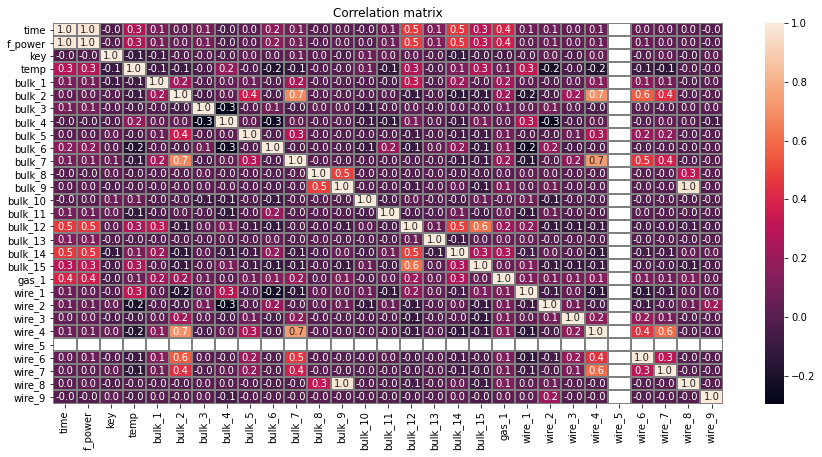

In [57]:
cm = feature.corr()
plt.figure(figsize=(15,7))
plt.title('Correlation matrix')
sns.heatmap(cm, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

In [58]:
X, X_test, y, y_test = train_test_split(
    feature.drop(['temp', 'key', 'measure_time', 'wire_5'], axis=1),
    feature.temp, test_size=0.4, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=12345)

In [59]:
print(X.shape, X_test.shape, X_valid.shape)

(1397, 26) (466, 26) (466, 26)


In [60]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.272364,0.407780,-0.264096,-0.059757,-0.612332,-0.626620,-0.131533,-0.404537,-0.065283,0.0,...,1.228051,-0.081236,-0.475266,-0.535888,-0.113971,-0.063768,-0.104688,-0.027493,-0.070961,-0.08256
1,0.460085,0.613646,-0.264096,-0.059757,1.699017,-0.626620,-0.131533,-0.404537,-0.065283,0.0,...,-0.197159,3.353008,-0.560416,-0.535888,-0.113971,-0.063768,-0.104688,-0.027493,-0.070961,-0.08256
2,0.067044,-0.179777,-0.264096,-0.059757,-0.612332,-0.626620,-0.131533,0.392261,-0.065283,0.0,...,-0.208937,0.581314,-0.976289,2.230725,-0.113971,-0.063768,-0.104688,-0.027493,-0.070961,-0.08256
3,1.228567,1.300205,-0.264096,-0.059757,-0.612332,-0.626620,-0.131533,-0.404537,-0.065283,0.0,...,-1.410353,0.492164,-1.697982,1.928981,-0.113971,-0.063768,-0.104688,-0.027493,-0.070961,-0.08256
4,1.562945,1.608068,3.651762,-0.059757,-0.612332,2.919159,-0.131533,-0.404537,-0.065283,0.0,...,0.992479,2.257619,0.245933,-0.535888,-0.113971,-0.063768,-0.104688,-0.027493,-0.070961,-0.08256


## Обучение

#### LGBMRegressor

In [74]:
# кросс_валидация
%%time
#best_model = None
best_mae = 4000
#best_count_eterations = 0
best_est = 0
best_depth = 0
for est in range(1, 30, 3):
    for depth in range(1, 12, 1):
        
        model = LGBMRegressor(random_state=12345, depth=depth, n_estimators=est)
        mae = cross_val_score(model, X, y, scoring=make_scorer(mean_absolute_error), cv=5, n_jobs=-1).mean()
        if mae < best_mae:
            #best_model = model
            best_mae = mae
            best_depth = depth
            best_est = est
            
        
print('MAE для LightGBM:', best_mae,'\nГлубина: 3\nКоличество деревьев:', best_est, '\n')

MAE для LightGBM: 7.115337253871713 
Глубина: 3
Количество деревьев: 25 

Wall time: 45.5 s


In [77]:
# без крос_валидации
%%time 

model = LGBMRegressor(random_state=12345, depth=3, n_estimators=25)
model.fit(X,y)
predictions = model.predict(X_valid)
mae = mean_absolute_error(y_valid, predictions).mean()

print('MAE для LightGBM:', mae,'\nГлубина: 3\nКоличество деревьев:', best_est, '\n')

[LightGBM] [Warning] Unknown parameter: depth
MAE для LightGBM: 6.880670469951761 
Глубина: 3
Количество деревьев: 25 

Wall time: 34.9 ms


In [78]:
# тест
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions).mean()

print('MAE для LightGBM:', mae,'\nГлубина: 3\nКоличество деревьев:', best_est, '\n')

MAE для LightGBM: 7.248762854862485 
Глубина: 3
Количество деревьев: 25 



#### Линейная регрессия

In [62]:
%%time
    
model = LinearRegression()
model.fit(X,y)
pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, pred)


print('MAE для линейной регрессии:', mae)


MAE для линейной регрессии: 7.19015758946652
Wall time: 4.99 ms


In [63]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)


print('MAE для линейной регрессии:', mae)


MAE для линейной регрессии: 7.282927929034507


#### Дерево решений

In [80]:
%%time
best_model = None
best_mae = 4000

for depth in range(1, 50, 3):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    mae = cross_val_score(model, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
    mae_dec = mae.mean()
    if mae_dec < best_mae:
        best_mae = mae_dec
        best_depth = depth
        best_model = model

print('RMSE для DecisionTreeRegressor:', best_mae,'\nГлубина:',best_depth,'\n')

RMSE для DecisionTreeRegressor: 7.583515384554604 
Глубина: 4 

Wall time: 782 ms


#### Случайный лес

In [91]:
%%time
best_model = None
best_mae = 4000
best_est = 0
best_depth = 0
for est in range( 9, 50, 3):
    for depth in range(1, 15, 3):
        model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
        mae = cross_val_score(model,  X, y, cv=5, scoring=make_scorer(mean_absolute_error))
        mae = mae.mean()
        if mae < best_mae:
            best_model = model
            best_mae = mae
            best_depth = depth
            best_est = est
            
print('RMSE для RandomForestRegressor:', best_mae,'\nГлубина:',best_depth,'\nКоличество деревьев:', best_est, '\n')

RMSE для RandomForestRegressor: 7.016591396047838 
Глубина: 10 
Количество деревьев: 21 

Wall time: 28.5 s


In [87]:
best_depth

11

#### Проверка важности

Feature: 0, Score: 5.10518
Feature: 1, Score: -1.51790
Feature: 2, Score: -1.37105
Feature: 3, Score: 2.42080
Feature: 4, Score: -0.53939
Feature: 5, Score: 0.30036
Feature: 6, Score: -0.27985
Feature: 7, Score: -1.04576
Feature: 8, Score: 0.90594
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.65551
Feature: 11, Score: 0.27758
Feature: 12, Score: -0.73184
Feature: 13, Score: 0.89904
Feature: 14, Score: -1.22059
Feature: 15, Score: -0.36335
Feature: 16, Score: 0.93952
Feature: 17, Score: -0.61086
Feature: 18, Score: 2.39042
Feature: 19, Score: -1.39609
Feature: 20, Score: -0.25128
Feature: 21, Score: -2.31121
Feature: 22, Score: -0.40332
Feature: 23, Score: -1.28635
Feature: 24, Score: 0.85192
Feature: 25, Score: 0.10511


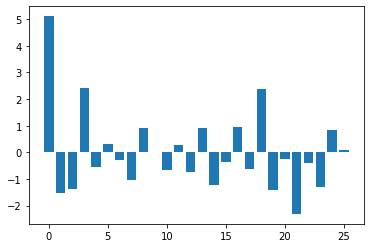

In [64]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()